In [1]:
import tensorflow as tf
import keras
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers
from keras.optimizers import Adam
import json
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf
import skimage
from skimage import color, exposure, transform

Using TensorFlow backend.


In [2]:
env = gym.make('PongDeterministic-v4')

[2017-12-24 16:00:48,085] Making new env: PongDeterministic-v4


In [3]:
ACTIONS = env.action_space.n # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 500. # timesteps to observe before training
EXPLORE = 300000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
INITIAL_EPSILON = 0.4 # starting value of epsilon
REPLAY_MEMORY = 30000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
LEARNING_RATE = 1e-5
SGD_LEARNING_RATE = 1e-3

img_rows , img_cols = 84, 84
#Convert image into Black and white
img_channels = 3 #We stack 3 frames

max_epLength = 500

NUM_EPISODES = 1000

SAVE_DIR = 'dqn_pong/'

In [4]:
import os
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [5]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [6]:
def build_model():
    
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=(4, 4), padding='valid',input_shape=(img_rows,img_cols,img_channels)))  #80*80*4
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    #model.add(Activation('tanh'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS, activation='linear'))

    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    #sgd = SGD(lr=SGD_LEARNING_RATE)
    #model.compile(loss='mse',optimizer=sgd)
    print("We finish building the model")
    return model

In [7]:
from skimage import data, io
from matplotlib import pyplot as plt
    
def show_as_img(arr):
    io.imshow(arr.reshape(img_rows, img_cols, 3))
    plt.show()

In [8]:
class Memory():
    def __init__(self, buff_sz):
        self.buff_sz = buff_sz
        self.M = deque()
    def append(self, tup):
        self.M.append(tup)
        if (len(self.M) > self.buff_sz):
            dump = self.M.popleft()
            if dump[2] > 0.0:
                if random.random() < 0.6:
                    self.append(dump)
            elif dump[2] < 0.0:
                if random.random() < 0.4:
                    self.append(dump)
    def sample(self, num_samples):
        minibatch = random.sample(self.M, num_samples)
        return minibatch
        #indices_random = random.randrange(0, len(self.M) - num_samples)
        #return list(self.M)[indices_random:indices_random + num_samples]

In [9]:
def save_model(model, path):
    model.save(path)

In [10]:
def process_frame(x_t):
    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(img_cols,img_rows), mode='constant')
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))
    x_t = x_t.reshape((1, img_cols, img_rows, 1))
    x_t /= 255.0
    return x_t

In [11]:
import time

TIMESTEP = 0

def train_model(model, env):
    
    M = Memory(REPLAY_MEMORY)
 
    OBSERVE = OBSERVATION
    epsilon = INITIAL_EPSILON

    t = 0
    
    rewards = []
    
    for idxEpisode in range(NUM_EPISODES):
        #Reset environment and get first new observation
        x_t = env.reset()
        x_t = process_frame(x_t)
        s_t = np.stack((x_t, x_t, x_t), axis=3)
        s_t = s_t.reshape(1, s_t.shape[1], s_t.shape[2], s_t.shape[3])
        d = False
        rAll = 0
        j = 0
        loss = 0.0
        ct_non_zero_reward = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            a_t = None
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < epsilon or t < OBSERVE:
                a_t = random.randrange(ACTIONS)
            else:
                q = model.predict(s_t)
                policy_max_Q = np.argmax(q)
                a_t = policy_max_Q
            x_t1,r_t,done,_ = env.step(a_t)
            x_t1 = process_frame(x_t1)
            s_t1 = np.append(x_t1, s_t[:, :, :, :2], axis=3)
            
            t += 1
            TIMESTEP = t
            M.append((s_t, a_t, r_t, s_t1, done))
            
            if epsilon > FINAL_EPSILON and t > OBSERVE:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
                minibatch = M.sample(BATCH)
                inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))
                targets = np.zeros((BATCH, ACTIONS))
                for i in range(0, BATCH):
                    state_t = minibatch[i][0]
                    action_t = minibatch[i][1]
                    reward_t = minibatch[i][2]
                    state_t1 = minibatch[i][3]
                    done_t = minibatch[i][4]

                    inputs[i] = state_t
                    targets[i] = model.predict(state_t)
                    Q_sa = model.predict(state_t1)
                    if done_t:
                        #print('targets before done', targets)
                        targets[i, action_t] = reward_t
                        #print('targets after done', targets)
                    else:
                        targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa[0])#[action_t]
                    if reward_t != 0.0:
                        ct_non_zero_reward += 1
                        #print('got reward', reward_t, 'for action', action_t)
                        #print('bef', model.predict(state_t))
                        #print('pred_s1', model.predict(state_t1))
                        #print('aft', targets)
                loss += model.train_on_batch(inputs, targets)
            rAll += r_t
            s_t = s_t1
            
            if done == True:
                break
            
        rewards.append(rAll)
        
        print('episode', idxEpisode, 'length', j, 'reward', rAll, 'epsilon', epsilon, 'loss sum', loss, 'non zero rewards', ct_non_zero_reward)
        
        if idxEpisode % 10 == 0:
            path = SAVE_DIR + 'model_episode_' + str(idxEpisode) + '.h5'
            save_model(model, path)
    return rewards

In [12]:
model = build_model()
#model = keras.models.load_model('/home/nikola/Faks/Diplomski/TreciSemestar/Projekt/atari_player/dqn_pong_me_200/model_episode_1600.h5')

We finish building the model


In [13]:
#model.lr = SGD_LEARNING_RATE

In [14]:
rewards = train_model(model, env)

episode 0 length 500 reward -9.0 epsilon 0.4 loss sum 0.0 non zero rewards 0
episode 1 length 500 reward -10.0 epsilon 0.3993500000000091 loss sum 1.53956439497 non zero rewards 305
episode 2 length 500 reward -10.0 epsilon 0.39870000000001815 loss sum 1.7388930644 non zero rewards 346
episode 3 length 500 reward -12.0 epsilon 0.3980500000000272 loss sum 1.6409951756 non zero rewards 326
episode 4 length 500 reward -10.0 epsilon 0.3974000000000363 loss sum 1.70418816511 non zero rewards 338
episode 5 length 500 reward -13.0 epsilon 0.39675000000004534 loss sum 1.51315217605 non zero rewards 299
episode 6 length 500 reward -13.0 epsilon 0.3961000000000544 loss sum 1.6260130126 non zero rewards 322
episode 7 length 500 reward -12.0 epsilon 0.3954500000000635 loss sum 1.84908266279 non zero rewards 366
episode 8 length 500 reward -9.0 epsilon 0.39480000000007254 loss sum 1.88522612078 non zero rewards 373
episode 9 length 500 reward -8.0 epsilon 0.3941500000000816 loss sum 1.88101587796 n

episode 78 length 500 reward -11.0 epsilon 0.34930000000070704 loss sum 0.654122104039 non zero rewards 388
episode 79 length 500 reward -10.0 epsilon 0.3486500000007161 loss sum 0.59667755384 non zero rewards 398
episode 80 length 500 reward -7.0 epsilon 0.3480000000007252 loss sum 0.692598280453 non zero rewards 388
episode 81 length 500 reward -11.0 epsilon 0.34735000000073424 loss sum 0.689215443213 non zero rewards 385
episode 82 length 500 reward -5.0 epsilon 0.3467000000007433 loss sum 0.681291565372 non zero rewards 389
episode 83 length 500 reward -11.0 epsilon 0.34605000000075237 loss sum 0.702637535898 non zero rewards 412
episode 84 length 500 reward -11.0 epsilon 0.34540000000076143 loss sum 0.69354128433 non zero rewards 387
episode 85 length 500 reward -8.0 epsilon 0.3447500000007705 loss sum 0.775364928675 non zero rewards 379
episode 86 length 500 reward -11.0 epsilon 0.34410000000077956 loss sum 0.759445479329 non zero rewards 438
episode 87 length 500 reward -11.0 ep

episode 155 length 500 reward -10.0 epsilon 0.299250000001405 loss sum 0.915075304103 non zero rewards 474
episode 156 length 500 reward -8.0 epsilon 0.29860000000141407 loss sum 0.878677566114 non zero rewards 456
episode 157 length 500 reward -10.0 epsilon 0.29795000000142313 loss sum 0.805440000884 non zero rewards 473
episode 158 length 500 reward -8.0 epsilon 0.2973000000014322 loss sum 0.841975886622 non zero rewards 456
episode 159 length 500 reward -5.0 epsilon 0.29665000000144126 loss sum 0.874914197222 non zero rewards 484
episode 160 length 500 reward -6.0 epsilon 0.2960000000014503 loss sum 0.847342220863 non zero rewards 496
episode 161 length 500 reward -7.0 epsilon 0.2953500000014594 loss sum 0.867217396299 non zero rewards 464
episode 162 length 500 reward -9.0 epsilon 0.29470000000146845 loss sum 0.871087930136 non zero rewards 481
episode 163 length 500 reward -5.0 epsilon 0.2940500000014775 loss sum 0.883386665315 non zero rewards 464
episode 164 length 500 reward -4

episode 232 length 500 reward -6.0 epsilon 0.24920000000208586 loss sum 0.837889641989 non zero rewards 448
episode 233 length 500 reward -3.0 epsilon 0.24855000000208105 loss sum 0.84094315843 non zero rewards 433
episode 234 length 500 reward -10.0 epsilon 0.24790000000207624 loss sum 0.932381271938 non zero rewards 428
episode 235 length 500 reward -6.0 epsilon 0.24725000000207142 loss sum 0.931056249421 non zero rewards 441
episode 236 length 500 reward -7.0 epsilon 0.2466000000020666 loss sum 0.892732430832 non zero rewards 459
episode 237 length 500 reward -4.0 epsilon 0.2459500000020618 loss sum 0.999139090418 non zero rewards 488
episode 238 length 500 reward -7.0 epsilon 0.24530000000205698 loss sum 0.947323494445 non zero rewards 469
episode 239 length 500 reward -6.0 epsilon 0.24465000000205217 loss sum 0.957011314924 non zero rewards 465
episode 240 length 500 reward -7.0 epsilon 0.24400000000204736 loss sum 0.958271256648 non zero rewards 494
episode 241 length 500 reward 

episode 309 length 500 reward -4.0 epsilon 0.19915000000171523 loss sum 0.762530277192 non zero rewards 370
episode 310 length 500 reward -3.0 epsilon 0.19850000000171042 loss sum 0.853218534496 non zero rewards 403
episode 311 length 500 reward -6.0 epsilon 0.1978500000017056 loss sum 0.815016754175 non zero rewards 368
episode 312 length 500 reward -7.0 epsilon 0.1972000000017008 loss sum 0.762860230752 non zero rewards 371
episode 313 length 500 reward -4.0 epsilon 0.19655000000169598 loss sum 0.80920515582 non zero rewards 339
episode 314 length 500 reward -3.0 epsilon 0.19590000000169117 loss sum 0.772053445951 non zero rewards 392
episode 315 length 500 reward -4.0 epsilon 0.19525000000168635 loss sum 0.80937166998 non zero rewards 381
episode 316 length 500 reward -6.0 epsilon 0.19460000000168154 loss sum 0.751165053924 non zero rewards 383
episode 317 length 500 reward -6.0 epsilon 0.19395000000167673 loss sum 0.797308900219 non zero rewards 365
episode 318 length 500 reward -5

episode 386 length 500 reward -6.0 epsilon 0.1491000000013446 loss sum 0.803242001333 non zero rewards 319
episode 387 length 500 reward -2.0 epsilon 0.1484500000013398 loss sum 0.855344059382 non zero rewards 386
episode 388 length 500 reward -2.0 epsilon 0.14780000000133497 loss sum 0.827559063648 non zero rewards 348
episode 389 length 500 reward -6.0 epsilon 0.14715000000133016 loss sum 0.827105249336 non zero rewards 348
episode 390 length 500 reward -4.0 epsilon 0.14650000000132535 loss sum 0.799465258984 non zero rewards 337
episode 391 length 500 reward -3.0 epsilon 0.14585000000132053 loss sum 0.794036490668 non zero rewards 368
episode 392 length 500 reward -1.0 epsilon 0.14520000000131572 loss sum 0.806094812113 non zero rewards 347
episode 393 length 500 reward -3.0 epsilon 0.1445500000013109 loss sum 0.823968740937 non zero rewards 376
episode 394 length 500 reward -5.0 epsilon 0.1439000000013061 loss sum 0.735473563051 non zero rewards 351
episode 395 length 500 reward -6

episode 463 length 500 reward 1.0 epsilon 0.099050000001251 loss sum 0.686949837283 non zero rewards 281
episode 464 length 500 reward -3.0 epsilon 0.09840000000125312 loss sum 0.640313190161 non zero rewards 293
episode 465 length 500 reward -2.0 epsilon 0.09775000000125525 loss sum 0.704815508681 non zero rewards 311
episode 466 length 500 reward 1.0 epsilon 0.09710000000125737 loss sum 0.619951740577 non zero rewards 260
episode 467 length 500 reward -4.0 epsilon 0.0964500000012595 loss sum 0.643258045864 non zero rewards 304
episode 468 length 500 reward -1.0 epsilon 0.09580000000126163 loss sum 0.707437346922 non zero rewards 311
episode 469 length 500 reward -4.0 epsilon 0.09515000000126375 loss sum 0.731707433035 non zero rewards 305
episode 470 length 500 reward -3.0 epsilon 0.09450000000126588 loss sum 0.669180222918 non zero rewards 278
episode 471 length 500 reward -2.0 epsilon 0.093850000001268 loss sum 0.686740315083 non zero rewards 288
episode 472 length 500 reward -2.0 

episode 540 length 500 reward -4.0 epsilon 0.0490000000013426 loss sum 0.63933873619 non zero rewards 284
episode 541 length 500 reward -2.0 epsilon 0.04835000000134126 loss sum 0.611832447918 non zero rewards 293
episode 542 length 500 reward -4.0 epsilon 0.047700000001339914 loss sum 0.619649753164 non zero rewards 293
episode 543 length 500 reward -2.0 epsilon 0.04705000000133857 loss sum 0.622655198938 non zero rewards 291
episode 544 length 500 reward -2.0 epsilon 0.046400000001337226 loss sum 0.630927111197 non zero rewards 292
episode 545 length 500 reward -1.0 epsilon 0.04575000000133588 loss sum 0.637458121375 non zero rewards 296
episode 546 length 500 reward 2.0 epsilon 0.04510000000133454 loss sum 0.630541600374 non zero rewards 297
episode 547 length 500 reward -1.0 epsilon 0.044450000001333194 loss sum 0.573135076629 non zero rewards 298
episode 548 length 500 reward 0.0 epsilon 0.04380000000133185 loss sum 0.625866899078 non zero rewards 265
episode 549 length 500 reward

episode 618 length 500 reward -2.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 619 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 620 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 621 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 622 length 500 reward -2.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 623 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 624 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 625 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 626 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 627 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 628 length 500 reward -3.0 epsilon 0.00999

episode 705 length 500 reward -2.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 706 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 707 length 500 reward -2.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 708 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 709 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 710 length 500 reward -5.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 711 length 500 reward 0.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 712 length 500 reward -4.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 713 length 500 reward -2.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 714 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 715 length 500 reward -3.0 epsilon 0.009998

episode 792 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 793 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 794 length 500 reward -2.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 795 length 500 reward 0.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 796 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 797 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 798 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 799 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 800 length 500 reward -5.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 801 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 802 length 500 reward 0.0 epsilon 0.0099987

episode 879 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 880 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 881 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 882 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 883 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 884 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 885 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 886 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 887 length 500 reward -2.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 888 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 889 length 500 reward 0.0 epsilon 0.009998

episode 966 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 967 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 968 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 969 length 500 reward -2.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 970 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 971 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 972 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 973 length 500 reward -1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 974 length 500 reward 1.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 975 length 500 reward -3.0 epsilon 0.00999870000131868 loss sum 0.0 non zero rewards 0
episode 976 length 500 reward -1.0 epsilon 0.009998

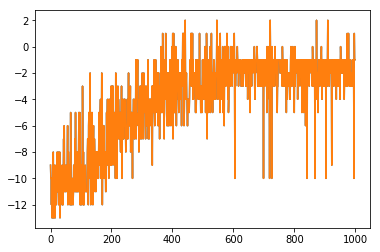

In [16]:
from matplotlib import pyplot as plt
plt.plot(range(len(rewards)), rewards)
plt.show()

test_model(model, Wrapped_Game(env))